# Setup


In [1]:
import importlib

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import shap
from IPython.display import display
from catboost import CatBoostClassifier
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier

import ml_pipe

importlib.reload(ml_pipe)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


<module 'ml_pipe' from '/home/konstantin/documents/pycharm_projects/praktikum_dsplus_master/notebooks/ml_pipe.py'>

In [2]:
# константы
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None

# тема графиков
pio.templates.default = "seaborn"  # plotly_dark seaborn
pio.renderers.default = "png"  # png notebook_connected plotly_mimetype

# Load data

In [3]:
def load_train() -> pd.DataFrame:
    """Load train data."""
    df = pd.read_csv('../data/train.csv')
    types = {
        bool: [
            'active',
            'alco',
            'cardio',
            'smoke',
        ],
        np.int8: [
            'cholesterol',
            'gender',
            'gluc',
        ]
    }
    for t, columns in types.items():
        for col in columns:
            df[col] = df[col].astype(t)
    return df


def load_test() -> pd.DataFrame:
    """Load test data."""
    return pd.read_csv('../data/test.csv')

In [4]:
df = load_train()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int8   
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int8   
 8   gluc         70000 non-null  int8   
 9   smoke        70000 non-null  bool   
 10  alco         70000 non-null  bool   
 11  active       70000 non-null  bool   
 12  cardio       70000 non-null  bool   
dtypes: bool(4), float64(1), int64(5), int8(3)
memory usage: 3.7 MB


In [6]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0


# EDA

In [7]:
df_eda = load_train()

## columns

### cardio (target)

In [8]:
print('Кол-во заболевших пациентов')
print(df_eda['cardio'].value_counts())

Кол-во заболевших пациентов
False    35021
True     34979
Name: cardio, dtype: int64


Кол-во значений "0" и "1" практически одинаково. Значит, с небалансом классов бороться не нужно.

### active

In [9]:
print('Кол-во пациентов по признаку active')
print(df_eda['active'].value_counts())

Кол-во пациентов по признаку active
True     56261
False    13739
Name: active, dtype: int64


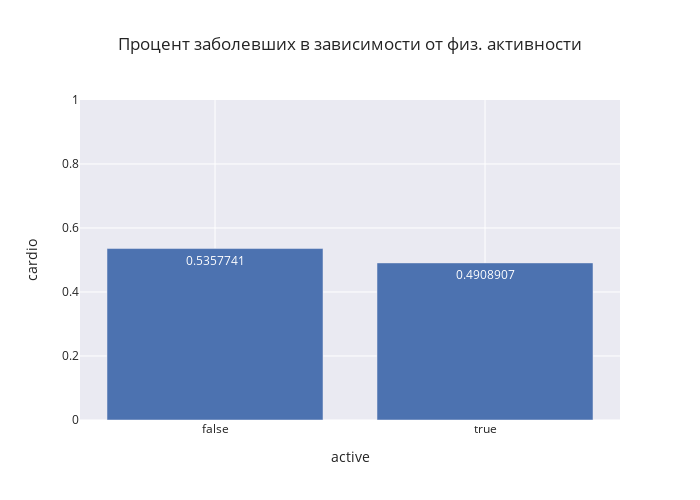

In [10]:
cardio_by_active = df_eda.pivot_table(index='active', values='cardio')

px.bar(
    cardio_by_active,
    x=cardio_by_active.index,
    y='cardio',
    title='Процент заболевших в зависимости от физ. активности',
    text_auto=True,
    range_y=(0, 1),
)

Физ. активность немного снижает риск болезни, хотя зависимость не сильная.

### age

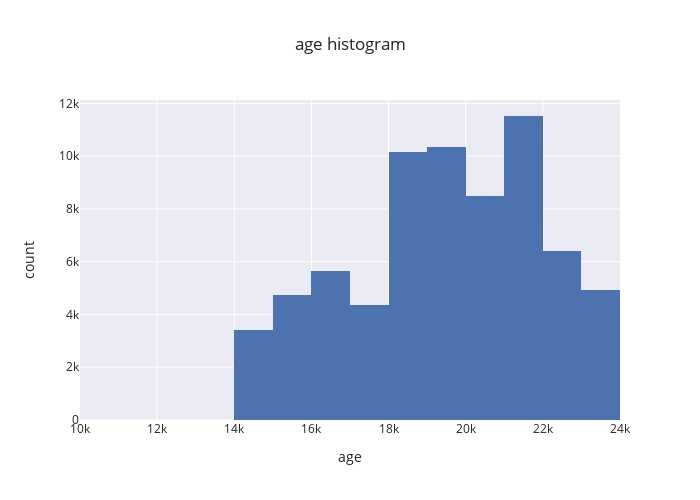

In [11]:
px.histogram(df_eda, x='age', nbins=25, title='age histogram')

Возраст, скорее всего, приводится в днях

In [12]:
print('Исходные данные:')
print(f'min = {df_eda["age"].min()}; max = {df_eda["age"].max()}')
print()

print('Если пересчитать в годы:')
print(
    f'min = {df_eda["age"].min() / 365:.1f}; max = {df_eda["age"].max() / 365:.1f}'
)

Исходные данные:
min = 10798; max = 23713

Если пересчитать в годы:
min = 29.6; max = 65.0


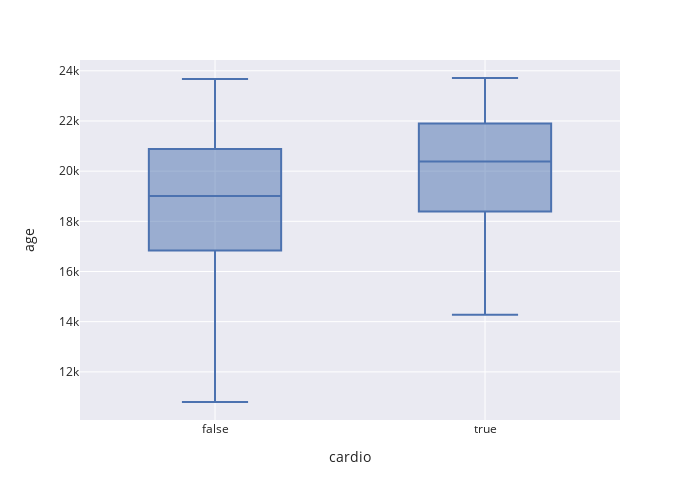

In [13]:
px.box(df_eda, x='cardio', y='age')

Чем старше человек - тем выше риск заболеть.

### alco

In [14]:
print('Кол-во пациентов по признаку alco')
print(df_eda['active'].value_counts())

Кол-во пациентов по признаку alco
True     56261
False    13739
Name: active, dtype: int64


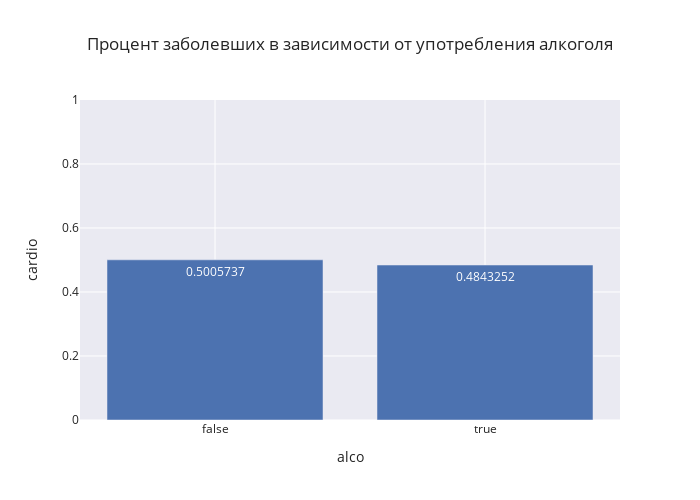

In [15]:
cardio_by_alco = df_eda.pivot_table(index='alco', values='cardio')

px.bar(
    cardio_by_alco,
    x=cardio_by_alco.index,
    y='cardio',
    title='Процент заболевших в зависимости от употребления алкоголя',
    text_auto=True,
    range_y=(0, 1),
)

### ap_hi

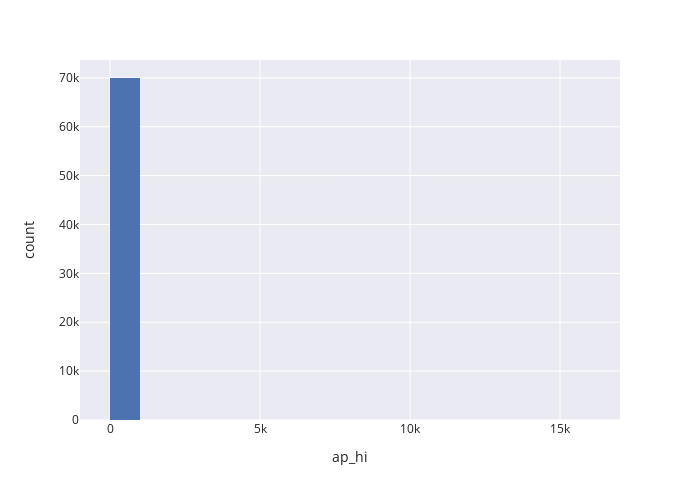

In [16]:
px.histogram(df_eda, x='ap_hi', nbins=20)

В данных явно есть выбросы. Отфильтруем

In [17]:
AP_HI__LOW = 80
AP_HI__HIGH = 220

df_ap_hi = make_pipeline(
    ml_pipe.OutliersToNAN('ap_hi', AP_HI__LOW, AP_HI__HIGH),
    ml_pipe.SimpleImputerMy('ap_hi'),
).fit_transform(df_eda)[['ap_hi', 'cardio']]

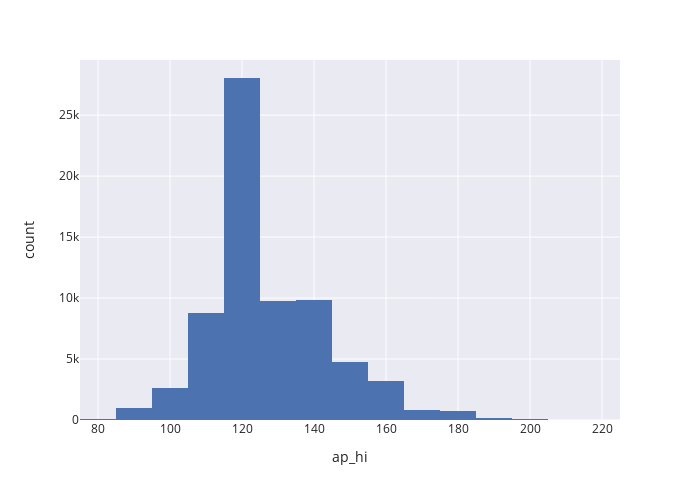

In [18]:
px.histogram(df_ap_hi, x='ap_hi', nbins=20)

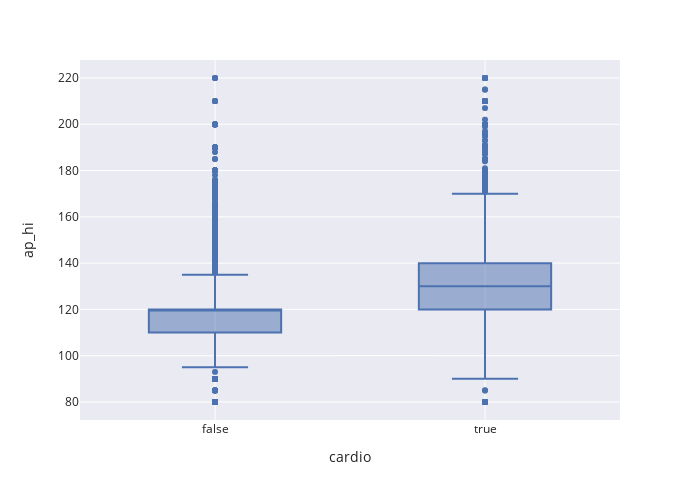

In [19]:
px.box(df_ap_hi, x='cardio', y='ap_hi')

Чем выше давление - тем выше заболеваемость.

### ap_lo

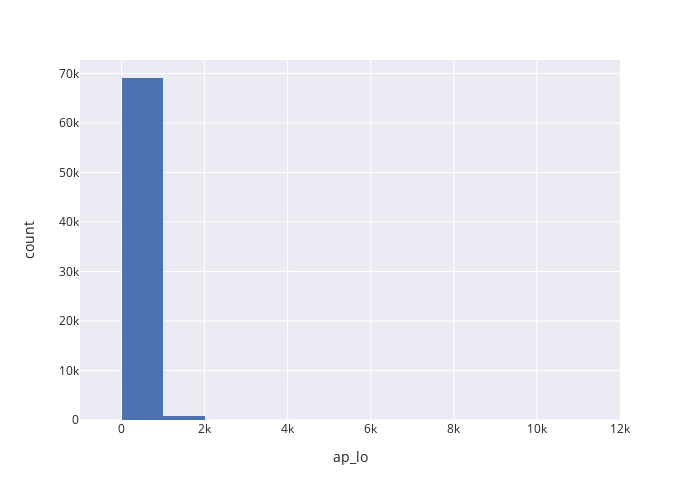

In [20]:
px.histogram(df_eda, x='ap_lo', nbins=20)

Аналогично верхнему давлению, здесь тоже есть выбросы.


In [21]:
AP_LO__LOW = 50
AP_LO__HIGH = 150

df_ap_lo = make_pipeline(
    ml_pipe.OutliersToNAN('ap_lo', AP_LO__LOW, AP_LO__HIGH),
    ml_pipe.SimpleImputerMy('ap_lo'),
).fit_transform(df_eda)[['ap_lo', 'cardio']]

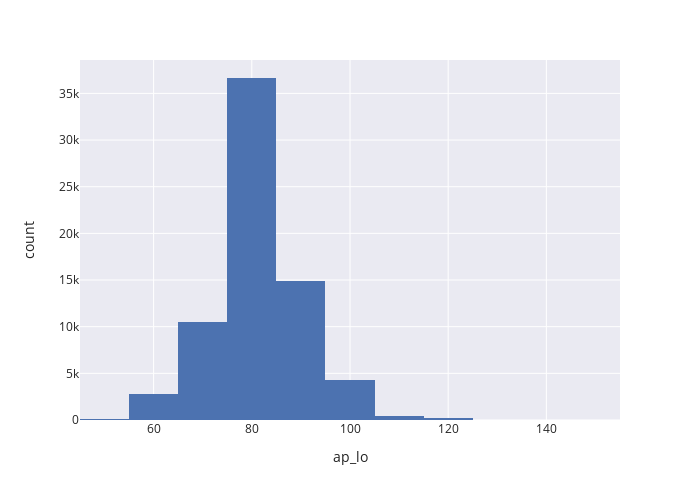

In [22]:
px.histogram(df_ap_lo, x='ap_lo', nbins=15)

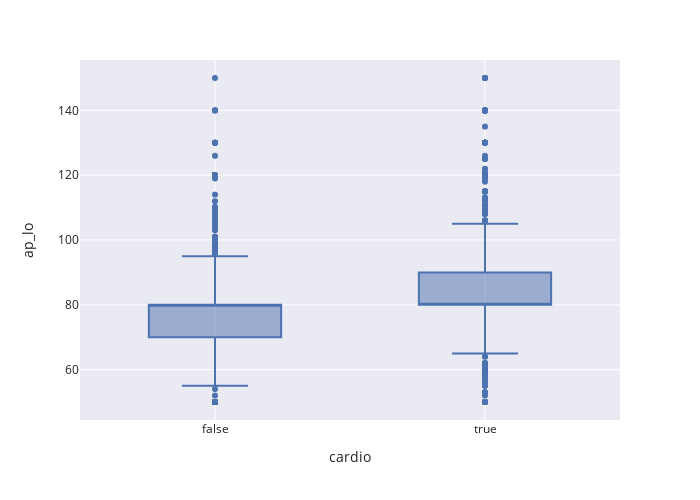

In [23]:
px.box(df_ap_lo, x='cardio', y='ap_lo')

### cholesterol

In [24]:
print('Кол-во пациентов по признаку cholesterol')
print(df_eda['cholesterol'].value_counts())

Кол-во пациентов по признаку cholesterol
1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64


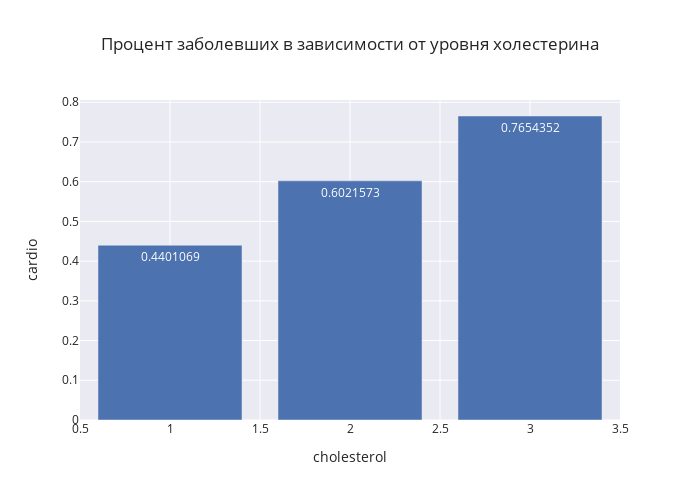

In [25]:
cardio_by_cholesterol = df_eda.pivot_table(
    index='cholesterol', values='cardio'
)

px.bar(
    cardio_by_cholesterol,
    x=cardio_by_cholesterol.index,
    y='cardio',
    title='Процент заболевших в зависимости от уровня холестерина',
    text_auto=True
)

### id

In [26]:
df_eda['id'].nunique()

70000

Все элементы в этой колонке уникальны. Признак бесполезен

In [27]:
def pre_id(df: pd.DataFrame) -> pd.DataFrame:
    """Clean id column."""
    return df.drop(columns=['id'])

### gender

In [28]:
print('Кол-во пациентов по признаку gender')
print(df_eda['gender'].value_counts())

Кол-во пациентов по признаку gender
1    45530
2    24470
Name: gender, dtype: int64


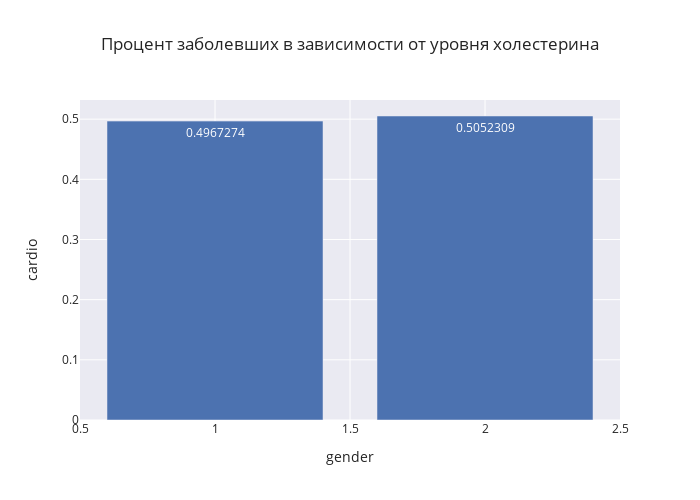

In [29]:
cardio_by_gender = df_eda.pivot_table(index='gender', values='cardio')

px.bar(
    cardio_by_gender,
    x=cardio_by_gender.index,
    y='cardio',
    title='Процент заболевших в зависимости от уровня холестерина',
    text_auto=True
)

### gluc

In [30]:
print('Кол-во пациентов по признаку gluc')
print(df_eda['gluc'].value_counts())

Кол-во пациентов по признаку gluc
1    59479
3     5331
2     5190
Name: gluc, dtype: int64


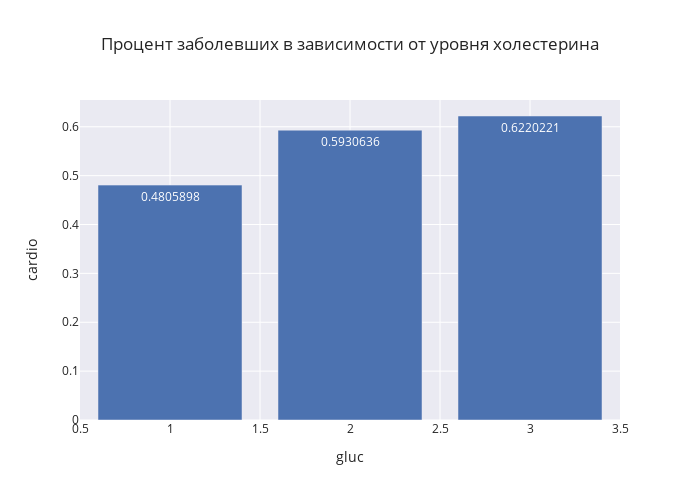

In [31]:
cardio_by_gluc = df_eda.pivot_table(index='gluc', values='cardio')

px.bar(
    cardio_by_gluc,
    x=cardio_by_gluc.index,
    y='cardio',
    title='Процент заболевших в зависимости от уровня холестерина',  # TODO
    text_auto=True
)

### height

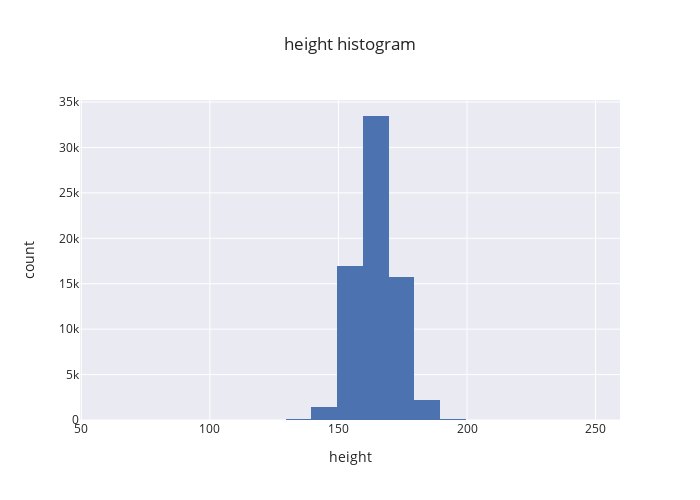

In [32]:
px.histogram(df_eda, x='height', nbins=25, title='height histogram')

In [33]:
HEIGHT__LOW = 140
HEIGHT__HIGH = 220

df_height = make_pipeline(
    ml_pipe.OutliersToNAN('height', HEIGHT__LOW, HEIGHT__HIGH),
    ml_pipe.SimpleImputerMy('height'),
).fit_transform(df_eda)

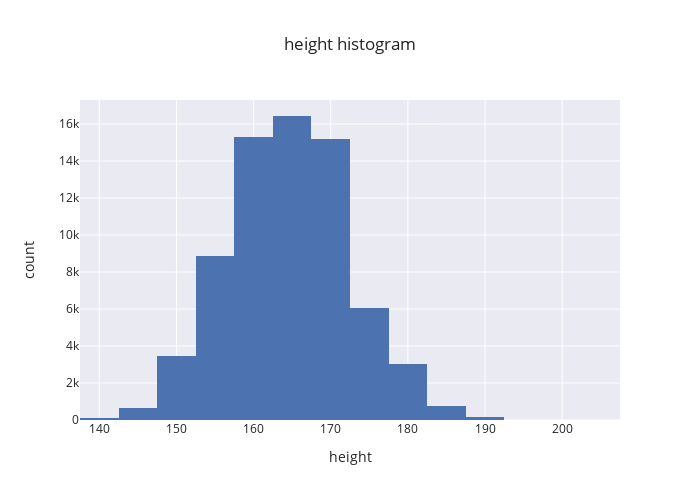

In [34]:
px.histogram(
    df_height, x='height', nbins=25, title='height histogram'
)

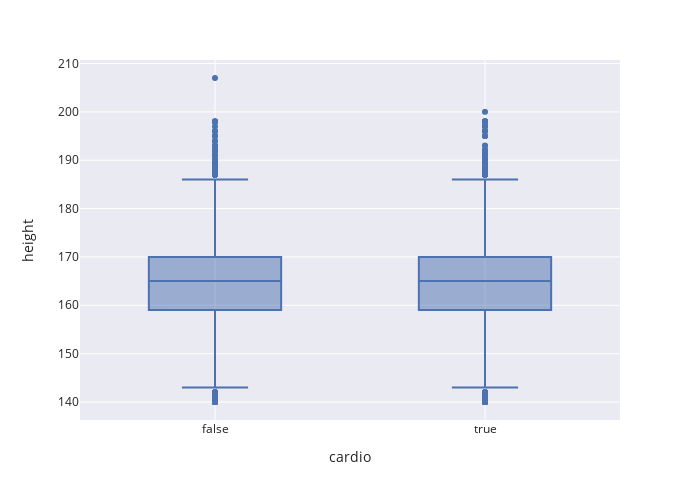

In [35]:
px.box(df_height, x='cardio', y='height')

От роста заболеваемость не зависит.

In [36]:
px.scatter(
    df_height,
    x='weight',
    y='height',
    title='Взаимосвязь верхнего и нижнего давлений',
)

print('Коэффициент корреляции:')
print(df_height['height'].corr(df_height['weight']))

Коэффициент корреляции:
0.3089151562883557


### smoke

In [37]:
print('Кол-во курящих / некурящих пациентов')
print(df_eda['smoke'].value_counts())

Кол-во курящих / некурящих пациентов
False    63831
True      6169
Name: smoke, dtype: int64


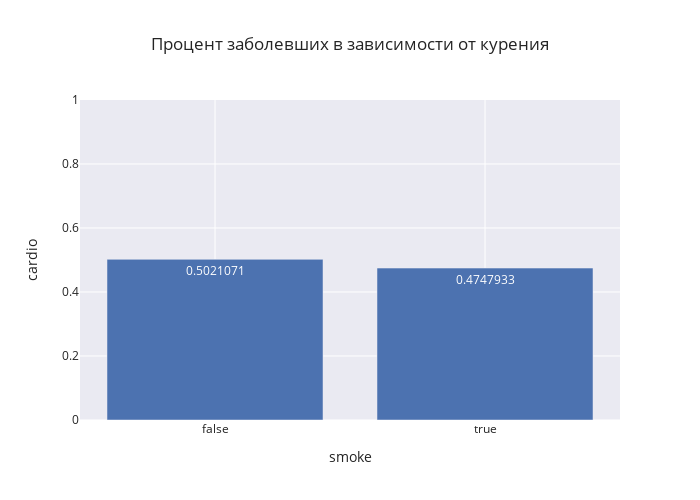

In [38]:
cardio_by_smoke = df_eda.pivot_table(index='smoke', values='cardio')

px.bar(
    cardio_by_smoke,
    x=cardio_by_smoke.index,
    y='cardio',
    title='Процент заболевших в зависимости от курения',
    text_auto=True,
    range_y=(0, 1),
)

### weight

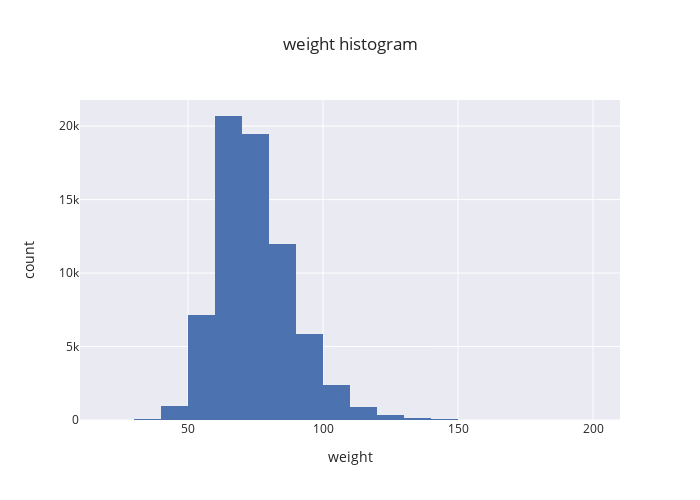

In [39]:
px.histogram(df_eda, x='weight', nbins=25, title='weight histogram')

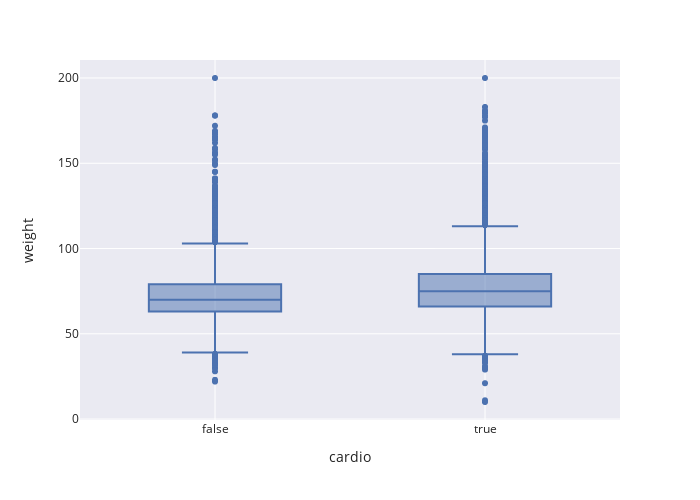

In [40]:
px.box(df_eda, x='cardio', y='weight')

## correlations

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.000000,0.003457,0.003502,-0.003038,-0.001830,0.003356,-0.002529,0.006106,0.002467,-0.003699,0.001210,0.003755,0.003799
age,0.003457,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,0.003502,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.003038,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,-0.001830,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.003356,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,-0.002529,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.006106,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.002467,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.003699,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486


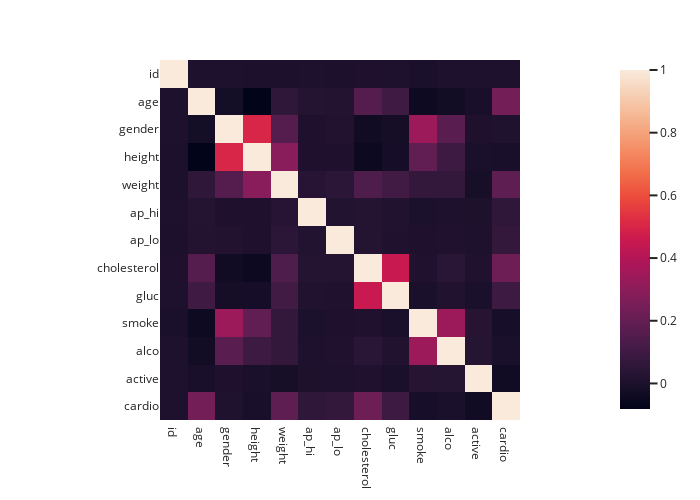

In [41]:
corr = df_eda.corr()

display(corr)

px.imshow(corr)

### ap_lo vs ap_hi

Верхнее и нижнее давления хорошо коррелируют между собой

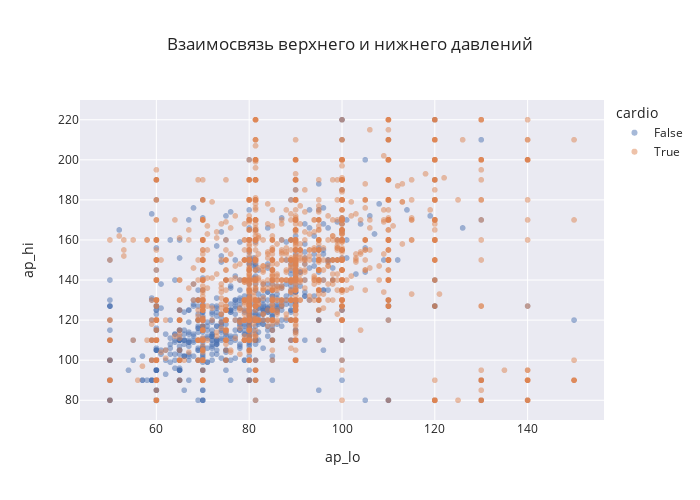

In [42]:
df_ap = df_ap_lo
df_ap['ap_hi'] = df_ap_hi['ap_hi']

px.scatter(
    df_ap,
    x='ap_lo',
    y='ap_hi',
    color='cardio',
    title='Взаимосвязь верхнего и нижнего давлений',
    opacity=0.5,
)

In [43]:
print('Коэффициент корреляции:')
print(df_ap['ap_lo'].corr(df_ap['ap_hi']))

Коэффициент корреляции:
0.6880125878218956


Можно заполнить неправильные значения, основываясь на значениях другого столбца

Значение верхнего давления должно быть меньше нижнего. В датасете есть неправильные данные. Скорее всего, это ошибка ввода и значения можно поменять друг с другом.

In [44]:
print('Процент записей с неправильным порядком значений давления: ')
print((len(df[df['ap_hi'] < df['ap_lo']]) / len(df_eda) * 100))

Процент записей с неправильным порядком значений давления: 
1.7628571428571427


### height vs weight

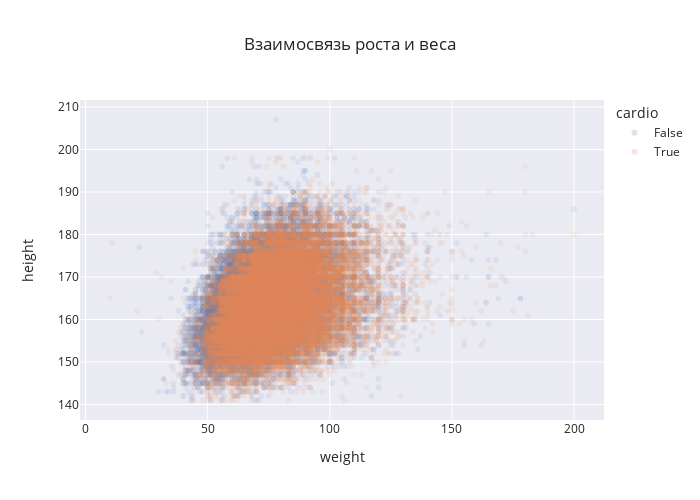

In [45]:
px.scatter(
    df_eda[(df['height'] < HEIGHT__HIGH) & (df['height'] > HEIGHT__LOW)],
    x='weight',
    y='height',
    color='cardio',
    title='Взаимосвязь роста и веса',
    opacity=0.1,
)

In [46]:
print('Коэффициент корреляции:')
print(df_eda['height'].corr(df_eda['weight']))

Коэффициент корреляции:
0.2909678349914984


Есть взаимосвязь роста и веса. Заполним неправильные значения роста на основе веса.

# Preprocess


Выделим признаки для обучения и целевой признак

In [47]:
FEATURES = ['active', 'age', 'alco', 'ap_hi', 'ap_lo', 'cholesterol', 'gender',
            'gluc', 'height', 'smoke', 'weight']
FEATURES_SCALE = ['age', 'ap_hi', 'ap_lo', 'height', 'weight', 'cholesterol',
                  'gluc']
FEATURES_ENCODE = []
TARGET = 'cardio'

df = load_train()
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

X = df[FEATURES]
y = df[TARGET]

Составим pipeline для предобработки

In [48]:
AP_HI__LOW = 70
AP_HI__HIGH = 250

AP_LO__LOW = 30
AP_LO__HIGH = 200

HEIGHT__LOW = 140
HEIGHT__HIGH = 220

pipe_preprocess = make_pipeline(
    # удалим экстремальные значения
    ml_pipe.OutliersToNAN('ap_hi', AP_HI__LOW, AP_HI__HIGH),
    ml_pipe.OutliersToNAN('ap_lo', AP_LO__LOW, AP_LO__HIGH),
    ml_pipe.OutliersToNAN('height', HEIGHT__LOW, HEIGHT__HIGH),
    # верхнее давление должно быть больше нижнего
    ml_pipe.SortInRow(['ap_hi', 'ap_lo'], ascending=False),
    # заполним пропуски давлений
    ml_pipe.IterativeImputerPd(['ap_hi', 'ap_lo']),
    # заполним пропуски роста
    ml_pipe.IterativeImputerPd(['height', 'weight']),
    # заполним все пропуски, если остались
    ml_pipe.SimpleImputerMy(FEATURES),
    # кодирование категорий
    ml_pipe.OneHotEncoderMy(FEATURES_ENCODE),
    # масштибирование
    ml_pipe.StandardScalerMy(FEATURES_SCALE),
)

In [49]:
display(
    pipe_preprocess.fit_transform(X).head(20)
)

,active,age,alco,ap_hi,ap_lo,cholesterol,gender,gluc,height,smoke,weight
0,1.0,-0.436062,0.0,-1.001881,-0.154131,-0.539322,2.0,-0.395720,0.452741,0.0,-0.847873
1,1.0,0.307686,0.0,0.758900,0.890973,2.400793,1.0,-0.395720,-1.084075,0.0,0.749831
2,0.0,-0.247997,0.0,0.171973,-1.199236,2.400793,1.0,-0.395720,0.068537,0.0,-0.708942
3,1.0,-0.748152,0.0,1.345827,1.936078,-0.539322,2.0,-0.395720,0.580809,0.0,0.541435
4,0.0,-0.808543,0.0,-1.588808,-2.244341,-0.539322,1.0,-0.395720,-1.084075,0.0,-1.264666
5,0.0,0.991043,0.0,-0.414954,-0.154131,0.930735,1.0,1.351719,-1.724415,0.0,-0.500546
6,1.0,1.071700,0.0,0.171973,-0.154131,2.400793,1.0,-0.395720,-0.956007,0.0,1.305554
7,1.0,1.262602,0.0,0.171973,0.890973,2.400793,2.0,3.099157,1.733422,0.0,1.444485
8,1.0,-0.729913,0.0,-1.001881,-1.199236,-0.539322,1.0,-0.395720,-0.827939,0.0,-0.222685
9,0.0,0.147993,0.0,-1.001881,-2.244341,-0.539322,1.0,-0.395720,-0.059531,0.0,-0.431081


# Models


В качестве метрики оптимизации выберем ROC AUC.

In [50]:
METRIC_FOR_OPTIM = 'roc_auc'

## Dummy

In [51]:
model_dummy = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', DummyClassifier(
            random_state=1,
        )),
    ],

)
params = {
    'model__strategy': ['most_frequent', 'prior', 'stratified', 'uniform']
}
cv_dummy = RandomizedSearchCV(
    estimator=model_dummy,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
)
cv_dummy.fit(X, y)

print(cv_dummy.best_score_)
print(cv_dummy.best_params_)

/home/konstantin/documents/pycharm_projects/praktikum_dsplus_master/.venv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



0.5009591144966483
{'model__strategy': 'stratified'}


## LogisticRegression

In [52]:
model_logreg = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', LogisticRegression(
            n_jobs=-1,
            random_state=1,
            max_iter=100,
        )),
    ]
)
params = {
    'model__C': stats.uniform(0.1, 2.0),
}
cv_logreg = RandomizedSearchCV(
    estimator=model_logreg,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
)
cv_logreg.fit(X, y)

print(cv_logreg.best_score_)
print(cv_logreg.best_params_)

0.793057626666265
{'model__C': 0.7046651452636795}


In [53]:
model_logreg = cv_logreg.best_estimator_
print(
    'Метрики на обучающей выборке:',
    cross_val_score(model_logreg, X, y, scoring=METRIC_FOR_OPTIM)
)

Метрики на обучающей выборке: [0.78762497 0.79680871 0.7963674  0.79670936 0.78777769]


## RandomForest

In [54]:
model_rfc = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', RandomForestClassifier(
            n_jobs=-1,
            random_state=1,
        )),
    ]
)
params = {
    'model__n_estimators': range(100, 500, 10),
    'model__max_depth': range(4, 20),
    'model__max_features': range(2, len(X.columns) + 1),
    'model__max_samples': stats.uniform(0.1, 0.9),
}
cv_rfc = RandomizedSearchCV(
    estimator=model_rfc,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
    n_iter=10,
)
cv_rfc.fit(X, y)

print(cv_rfc.best_score_)
print(cv_rfc.best_params_)

0.8022336096389374
{'model__max_depth': 13, 'model__max_features': 3, 'model__max_samples': 0.2263482447357104, 'model__n_estimators': 420}


In [55]:
model_rfc = cv_rfc.best_estimator_
print(
    'Метрики на обучающей выборке:',
    cross_val_score(model_rfc, X, y, scoring=METRIC_FOR_OPTIM)
)

Метрики на обучающей выборке: [0.79809454 0.8072065  0.80403613 0.80421626 0.79761462]


## HistGradientBoosting

In [56]:
model_boost = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', HistGradientBoostingClassifier(
            random_state=1,
            max_iter=1000,
            max_bins=255,
        )),
    ]
)
params = {
    'model__learning_rate': stats.uniform(0.001, 0.2),
    'model__max_depth': range(4, 10),
    'model__l2_regularization': stats.uniform(0, 50.0),
}
cv_boost = RandomizedSearchCV(
    estimator=model_boost,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
    n_iter=5,
)
cv_boost.fit(X, y)

print(cv_boost.best_score_)
print(cv_boost.best_params_)

0.8032123222257892
{'model__l2_regularization': 34.26097501983797, 'model__learning_rate': 0.04189044994630349, 'model__max_depth': 6}


In [57]:
model_boost = cv_boost.best_estimator_
print(
    'Метрики на обучающей выборке:',
    cross_val_score(model_boost, X, y, scoring=METRIC_FOR_OPTIM)
)

Метрики на обучающей выборке: [0.79870362 0.80725194 0.8056865  0.80572084 0.79869871]


## Stacking

In [58]:
model_stack = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', StackingClassifier(
            estimators=[
                ('logreg', LogisticRegression(
                    random_state=1,
                )),
                ('rfc', RandomForestClassifier(
                    random_state=1,
                    n_estimators=cv_rfc.best_params_['model__n_estimators'],
                    max_depth=cv_rfc.best_params_['model__max_depth'],
                    max_features=cv_rfc.best_params_['model__max_features'],
                    max_samples=cv_rfc.best_params_['model__max_samples'],
                ))
            ],
            final_estimator=HistGradientBoostingClassifier(
                random_state=1,
            )
        )),
    ]
)
params = {
    'model__final_estimator__learning_rate': stats.uniform(0.001, 0.2),
    'model__final_estimator__max_iter': [40000],
    'model__final_estimator__max_depth': range(4, 10),
    'model__final_estimator__l2_regularization': stats.uniform(0, 10.0),
}
cv_stack = RandomizedSearchCV(
    estimator=model_stack,
    param_distributions=params,
    random_state=1,
    n_jobs=-1,
    scoring=METRIC_FOR_OPTIM,
    cv=5,
    n_iter=10,
)
# cv_stack.fit(X, y)
#
# print(cv_stack.best_score_)
# print(cv_stack.best_params_)

## XGBoost


In [59]:
model_xgboost = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', XGBClassifier(
            seed=1,
            eval_metric='auc',
            learning_rate=0.3,
        )),
    ]
)
params = {
    'model__max_depth': range(4, 6),
}
# cv_xgboost = RandomizedSearchCV(
#     estimator=model_xgboost,
#     param_distributions=params,
#     random_state=1,
#     n_jobs=-1,
#     scoring=METRIC_FOR_OPTIM,
#     cv=3,
# )
# cv_xgboost.fit(X, y)
# print(cv_xgboost.best_score_)
# print(cv_xgboost.best_params_)

## CatBoost


In [60]:
model_catboost = Pipeline(
    [
        ('pre', pipe_preprocess),
        ('model', CatBoostClassifier(
            random_state=1,
            verbose=False,
        )),
    ]
)
params = {
    'model__max_depth': [4, 7, 10],
    'model__l2_leaf_reg': [1, 4, 9],
    'model__learning_rate': [0.03, 0.1, 0.15],
    'model__iterations': [300],
}
# cv_catboost = RandomizedSearchCV(
#     estimator=model_catboost,
#     param_distributions=params,
#     random_state=1,
#     n_jobs=-1,
#     scoring=METRIC_FOR_OPTIM,
#     cv=3,
# )
# cv_catboost.fit(X, y)
# print(cv_catboost.best_score_)
# print(cv_catboost.best_params_)

In [61]:
# model_catboost.set_params(**cv_catboost.best_params_)
# model_catboost.fit(X, y)

# Inspection


## Permutation importance

In [62]:
result = permutation_importance(
    estimator=model_boost,
    X=X,
    y=y,
    n_repeats=5,
    random_state=1,
    n_jobs=-1,
)
display(
    ml_pipe.display_permutation_importance(
        result=result,
        x_columns=X.columns,
    )
)

,feature,mean,std
3,ap_hi,0.152134,0.001847
5,cholesterol,0.034786,0.001163
1,age,0.031034,0.001321
10,weight,0.005014,0.000564
4,ap_lo,0.004691,0.000632
0,active,0.002763,0.000356
8,height,0.002060,0.000206
7,gluc,0.001590,0.000073
6,gender,0.001176,0.000243
9,smoke,0.000689,0.000263


## Shap


Permutation explainer: 501it [01:40,  4.59it/s]                         


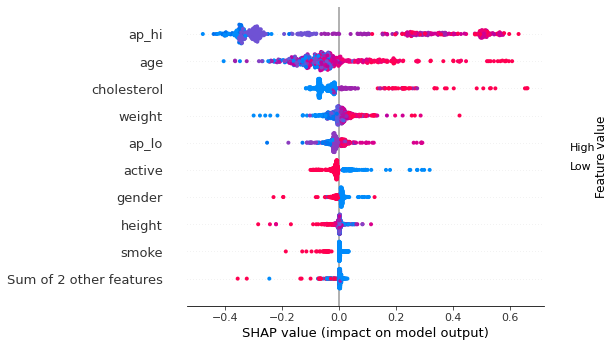

In [63]:
X_shap = model_boost[:-1].transform(X).sample(n=500, random_state=1)

shap_explainer = shap.Explainer(
    model=model_boost[-1].predict,
    masker=X_shap,
)
shap_values = shap_explainer(X_shap)

shap.plots.beeswarm(shap_values)

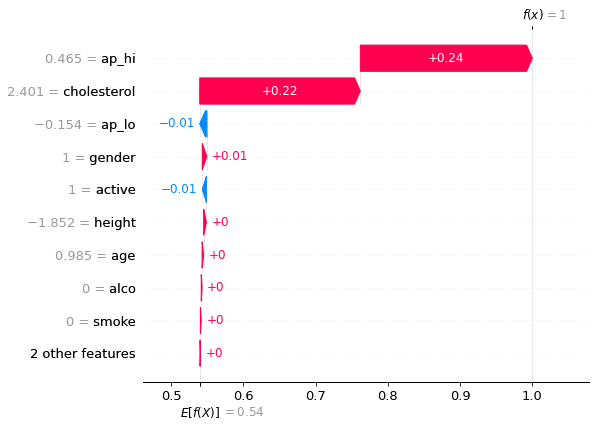

In [64]:
patient_with_cardio = {
    'active': 1,
    'age': 60 * 365,
    'alco': 0,
    'ap_hi': 135,
    'ap_lo': 80,
    'cholesterol': 3,
    'gender': 1,
    'gluc': 1,
    'height': 150,
    'smoke': 0,
    'weight': 70,
}
patient_with_cardio = model_boost[:-1].transform(
    pd.DataFrame([patient_with_cardio])
)
shap.plots.waterfall(shap_explainer(patient_with_cardio)[0])

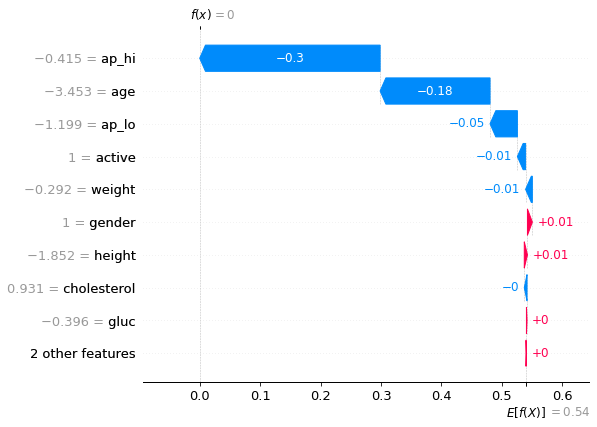

In [65]:
patient_without_cardio = {
    'active': 1,
    'age': 30 * 365,
    'alco': 0,
    'ap_hi': 120,
    'ap_lo': 70,
    'cholesterol': 2,
    'gender': 1,
    'gluc': 1,
    'height': 150,
    'smoke': 0,
    'weight': 70,
}
patient_without_cardio = model_boost[:-1].transform(
    pd.DataFrame([patient_without_cardio])
)
shap.plots.waterfall(shap_explainer(patient_without_cardio)[0])

# Submission

In [66]:
model_for_submit = model_boost

df_subm = load_test()

submission = pd.DataFrame(
    data=model_for_submit.predict(df_subm[FEATURES]),
    index=df_subm['id'],
    columns=[TARGET],
)
submission['cardio'] = submission['cardio'].astype(float)
submission.to_csv('../data/my_submission.csv')
